# PDF and Images Content Extraction for Large Language Models

In [ ]:
pip install -U boto3 pypdfium2 matplotlib easyocr ragstack-ai certifi PyPDF2 pdf2image pdfminer pdfminer.six pillow_heif pikepdf pypdf

In [2]:
import pypdfium2 as pdfium
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

In [3]:
def convert_pdf_to_images(file_path, scale=300/72):
    
    pdf_file = pdfium.PdfDocument(file_path)  
    page_indices = [i for i in range(len(pdf_file))]
    
    renderer = pdf_file.render(
        pdfium.PdfBitmap.to_pil,
        page_indices = page_indices, 
        scale = scale,
    )
    
    list_final_images = [] 
    
    for i, image in zip(page_indices, renderer):
        
        image_byte_array = BytesIO()
        image.save(image_byte_array, format='jpeg', optimize=True)
        image_byte_array = image_byte_array.getvalue()
        list_final_images.append(dict({i:image_byte_array}))
    
    return list_final_images

In [4]:
def display_images(list_dict_final_images):
    
    all_images = [list(data.values())[0] for data in list_dict_final_images]

    for index, image_bytes in enumerate(all_images):

        image = Image.open(BytesIO(image_bytes))
        figure = plt.figure(figsize = (image.width / 100, image.height / 100))

        plt.title(f"----- Page Number {index+1} -----")
        plt.imshow(image)
        plt.axis("off")
        plt.show()

In [5]:
convert_pdf_to_images = convert_pdf_to_images('Sample_notes_6-10.pdf')

In [8]:
#convert_pdf_to_images

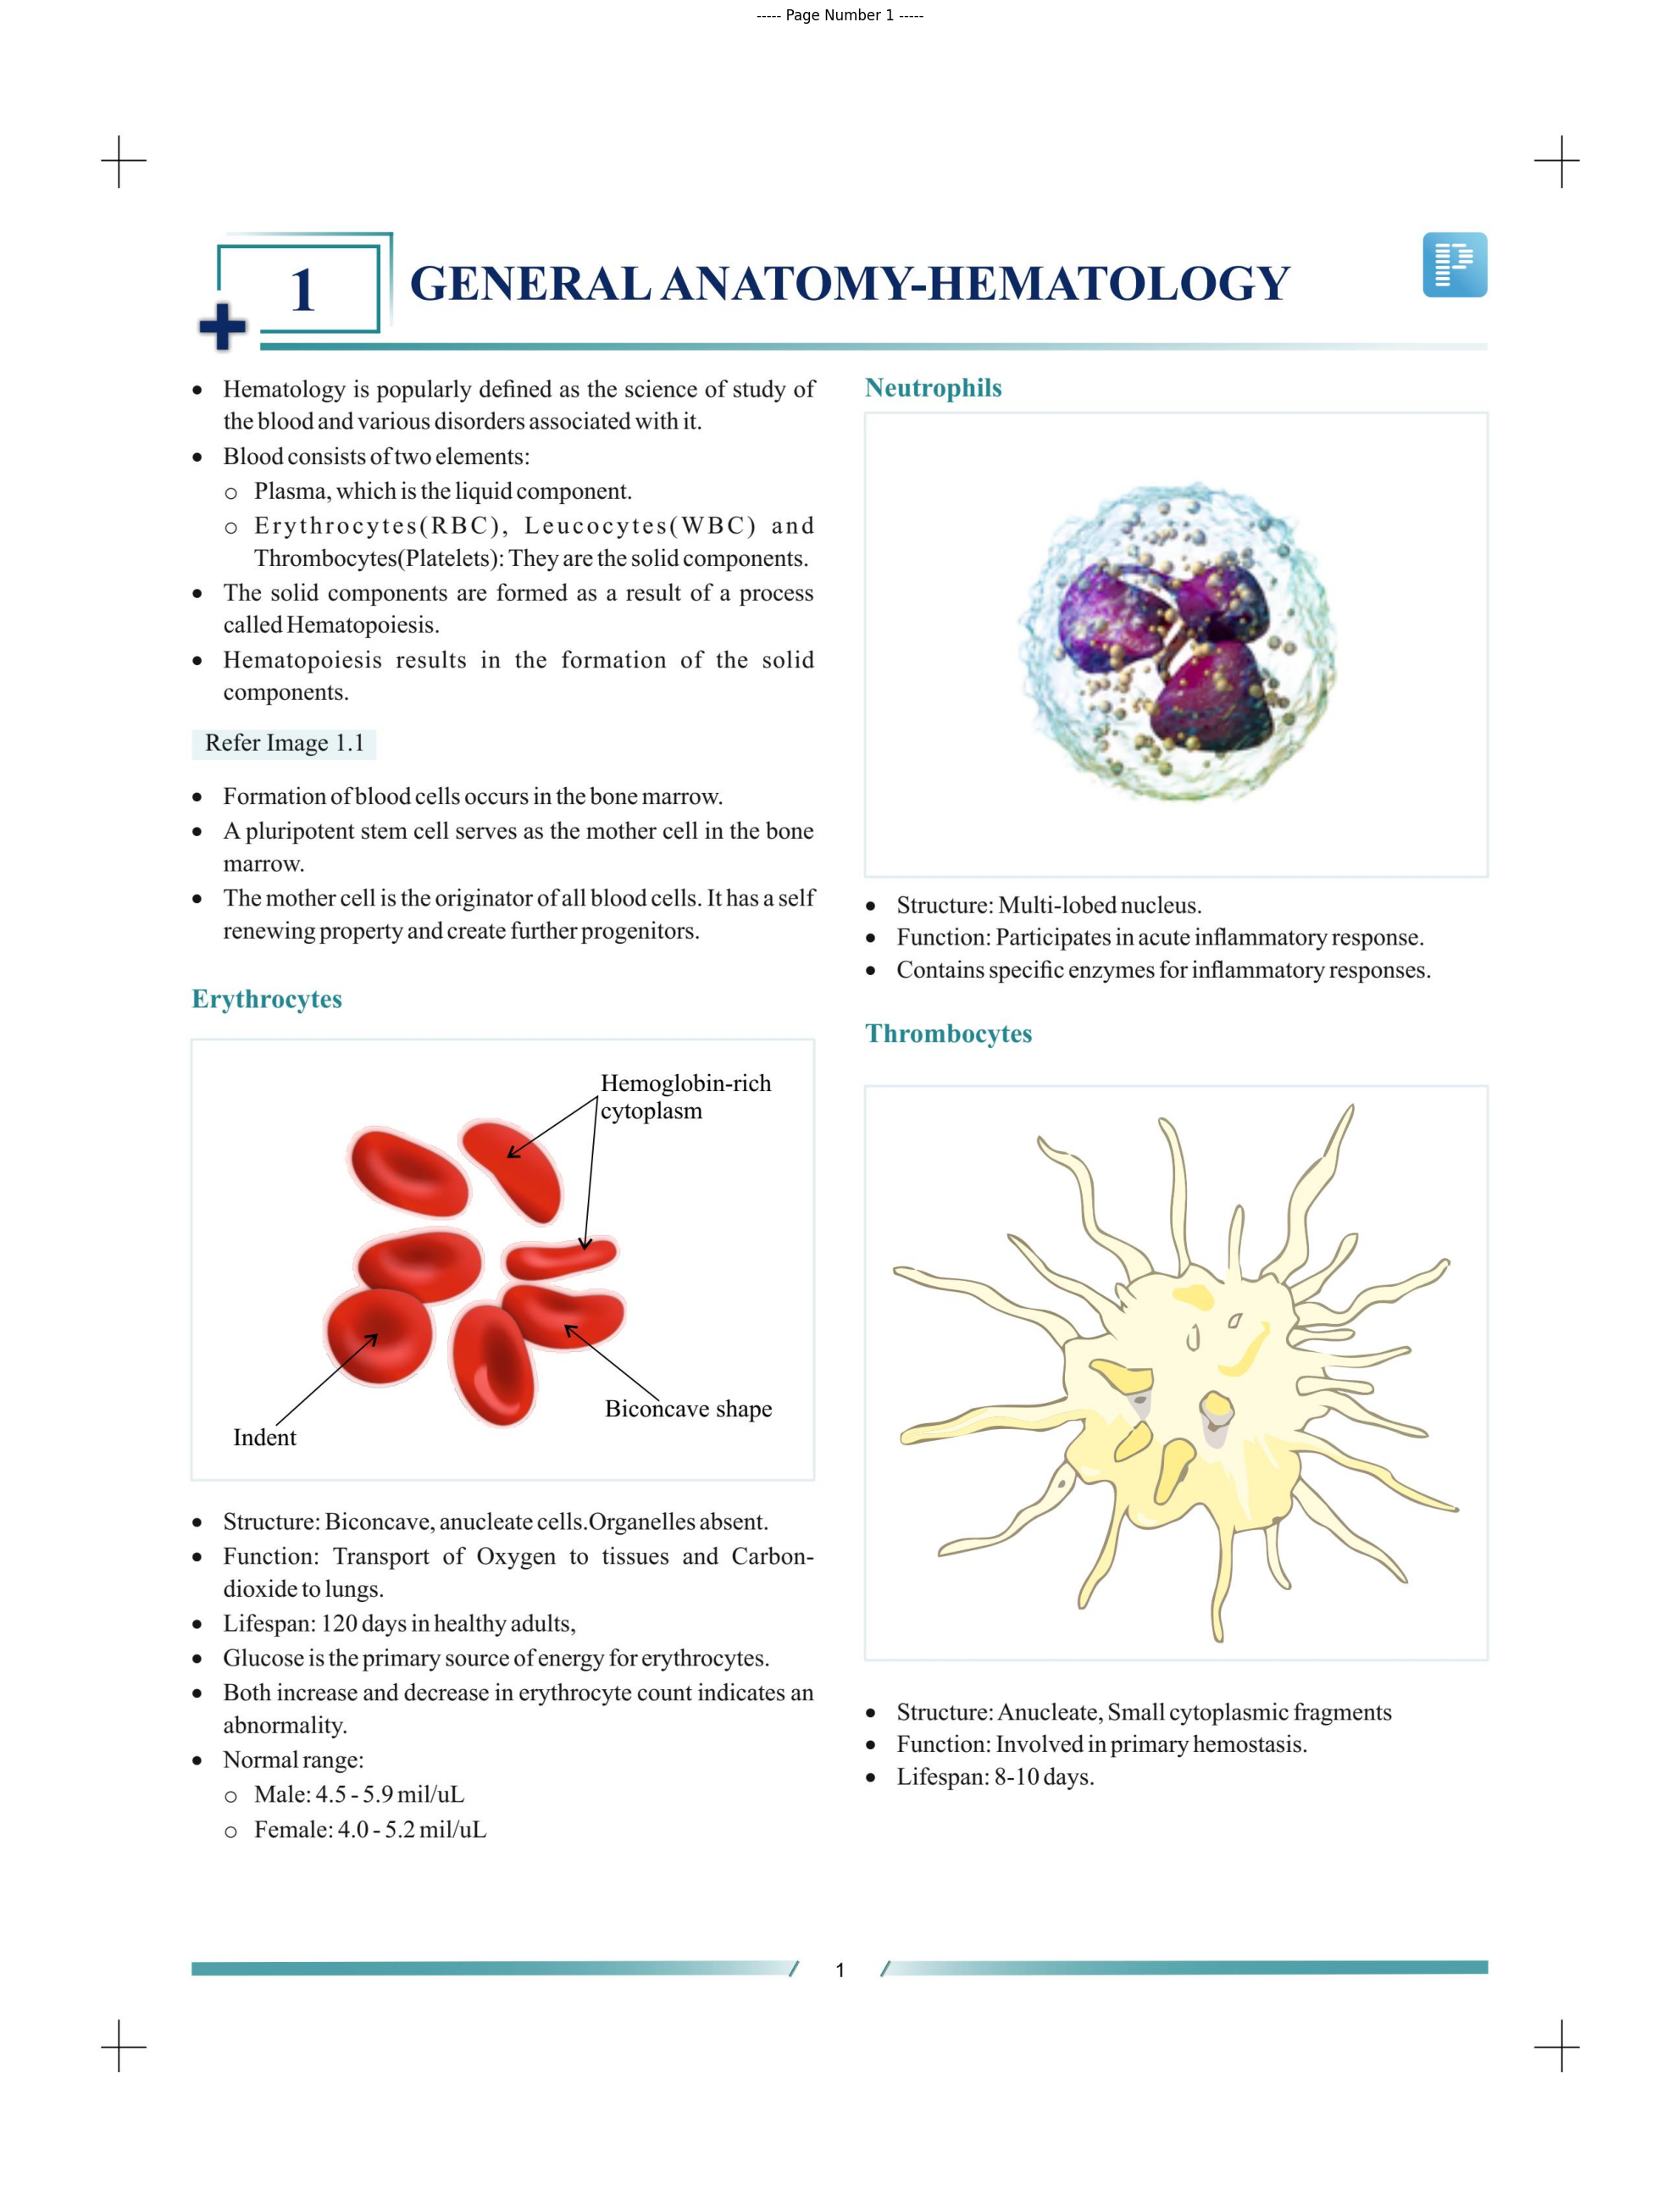

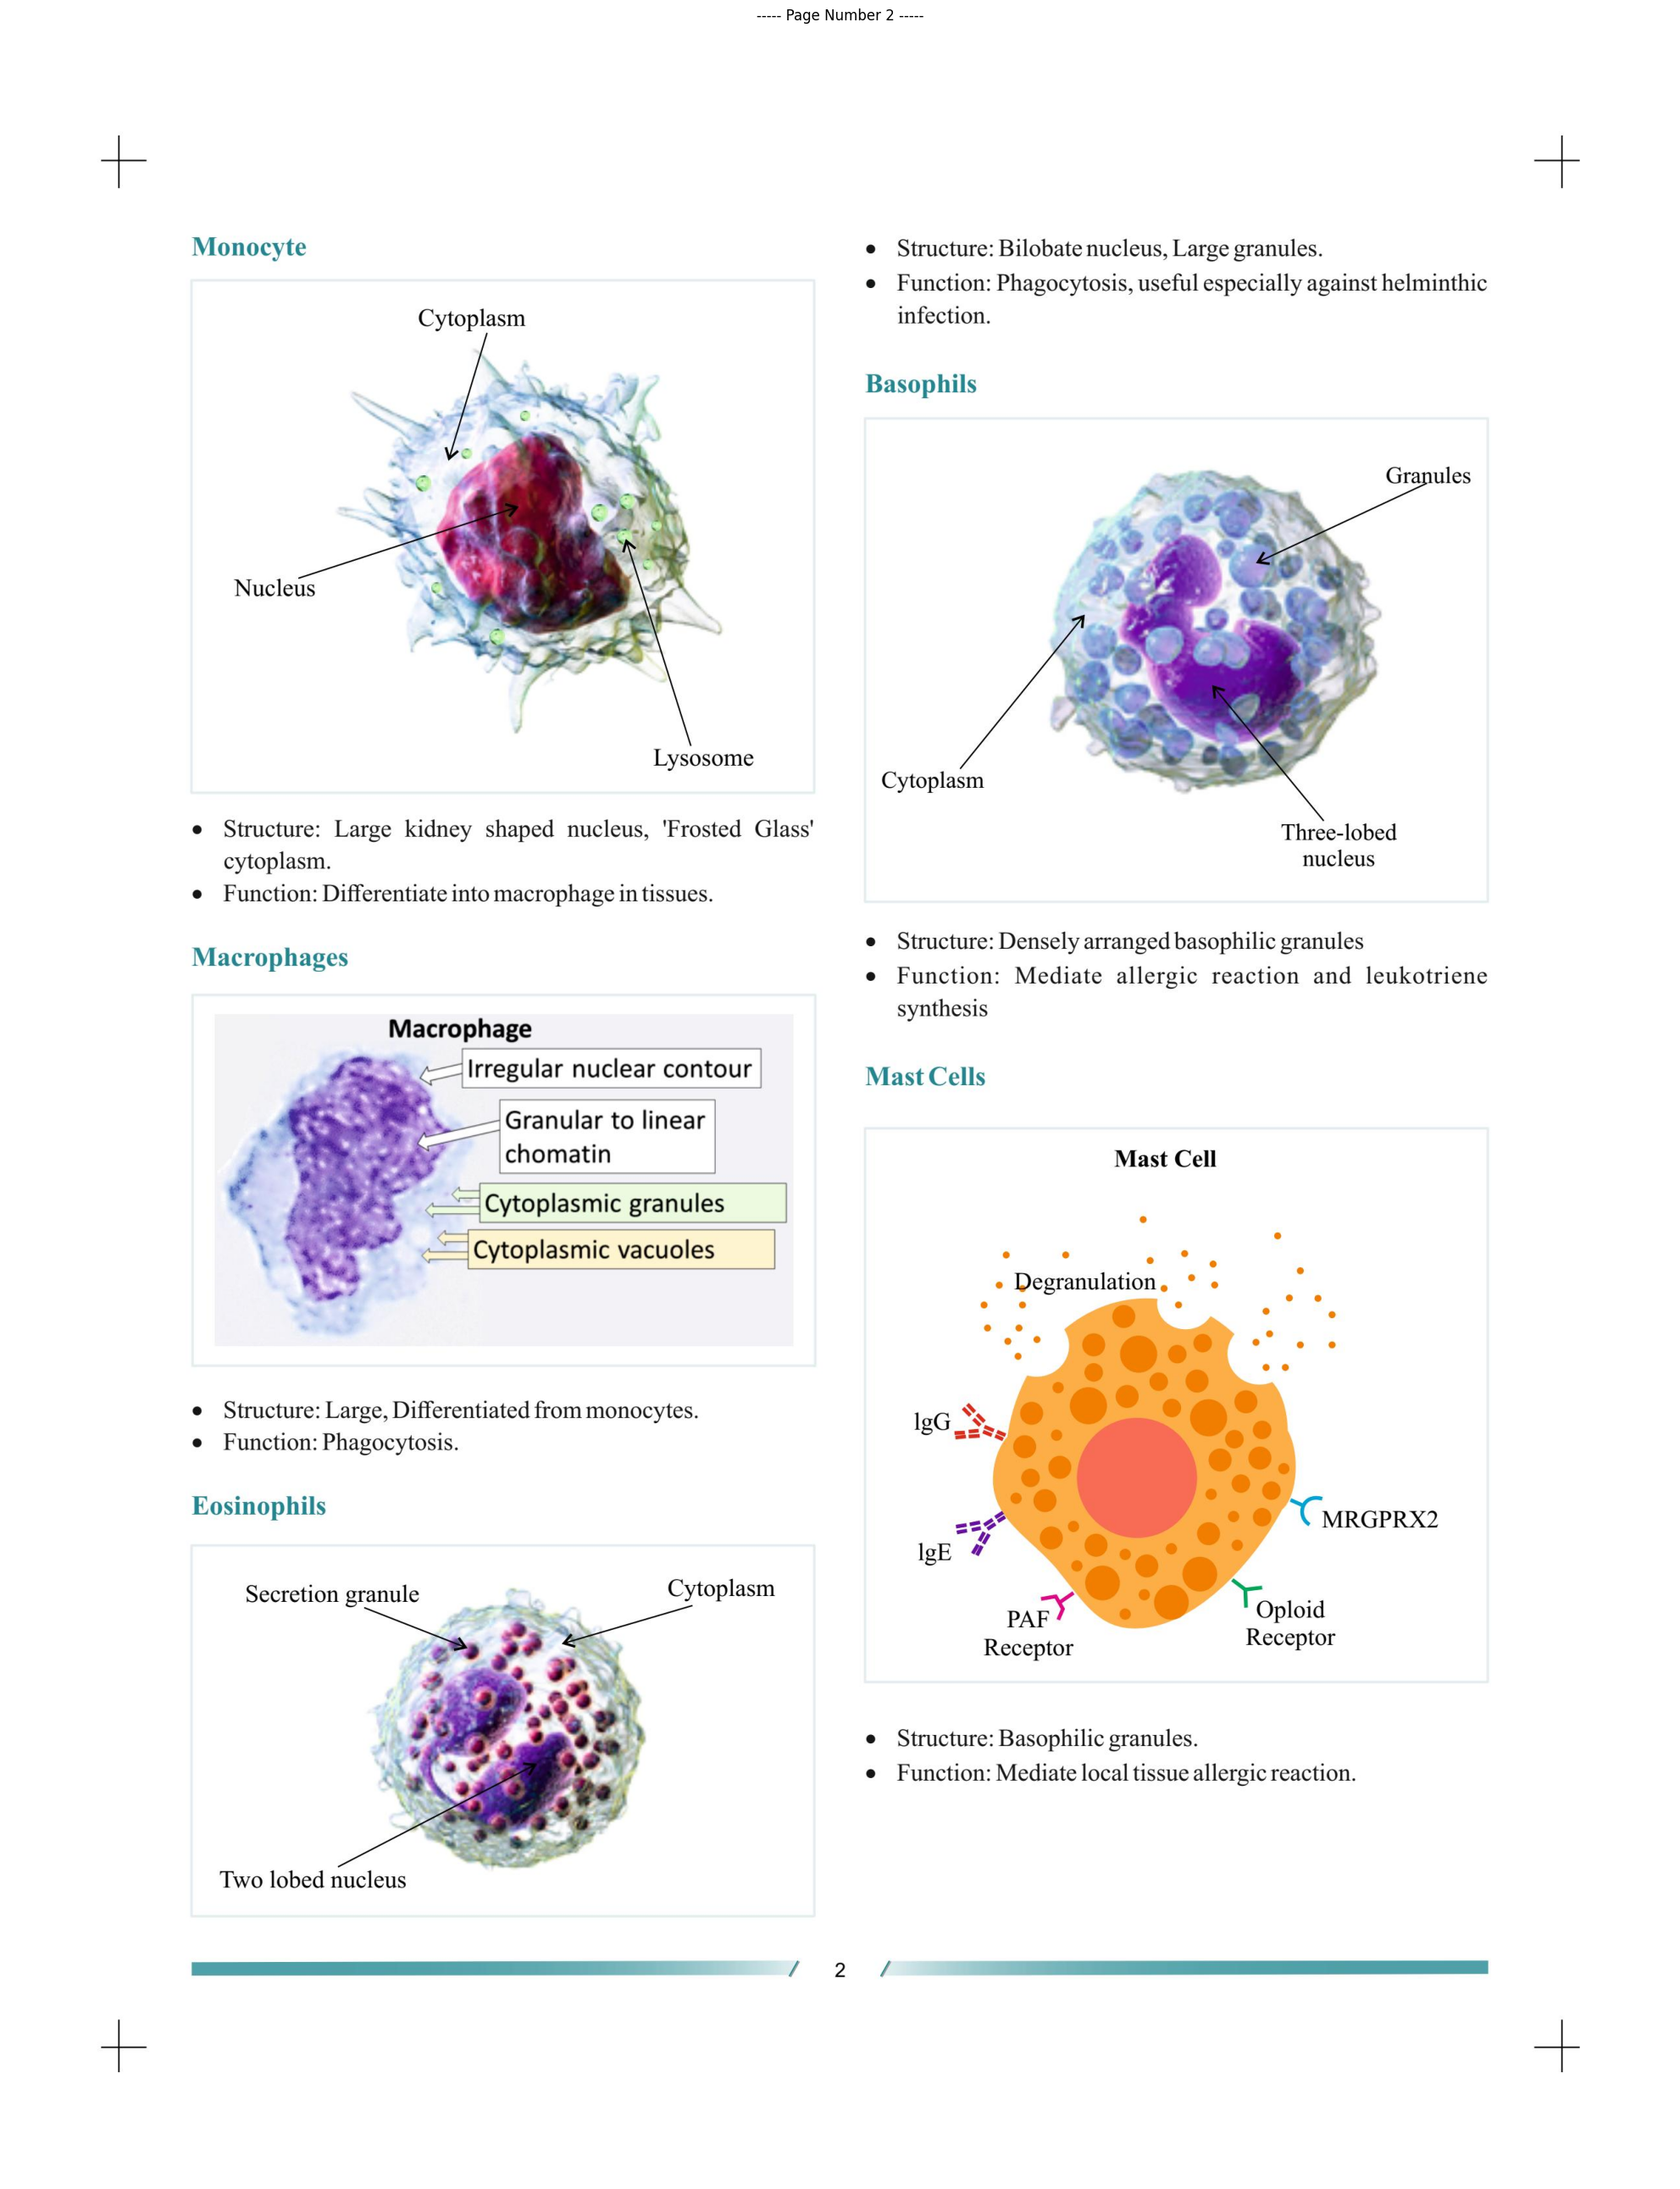

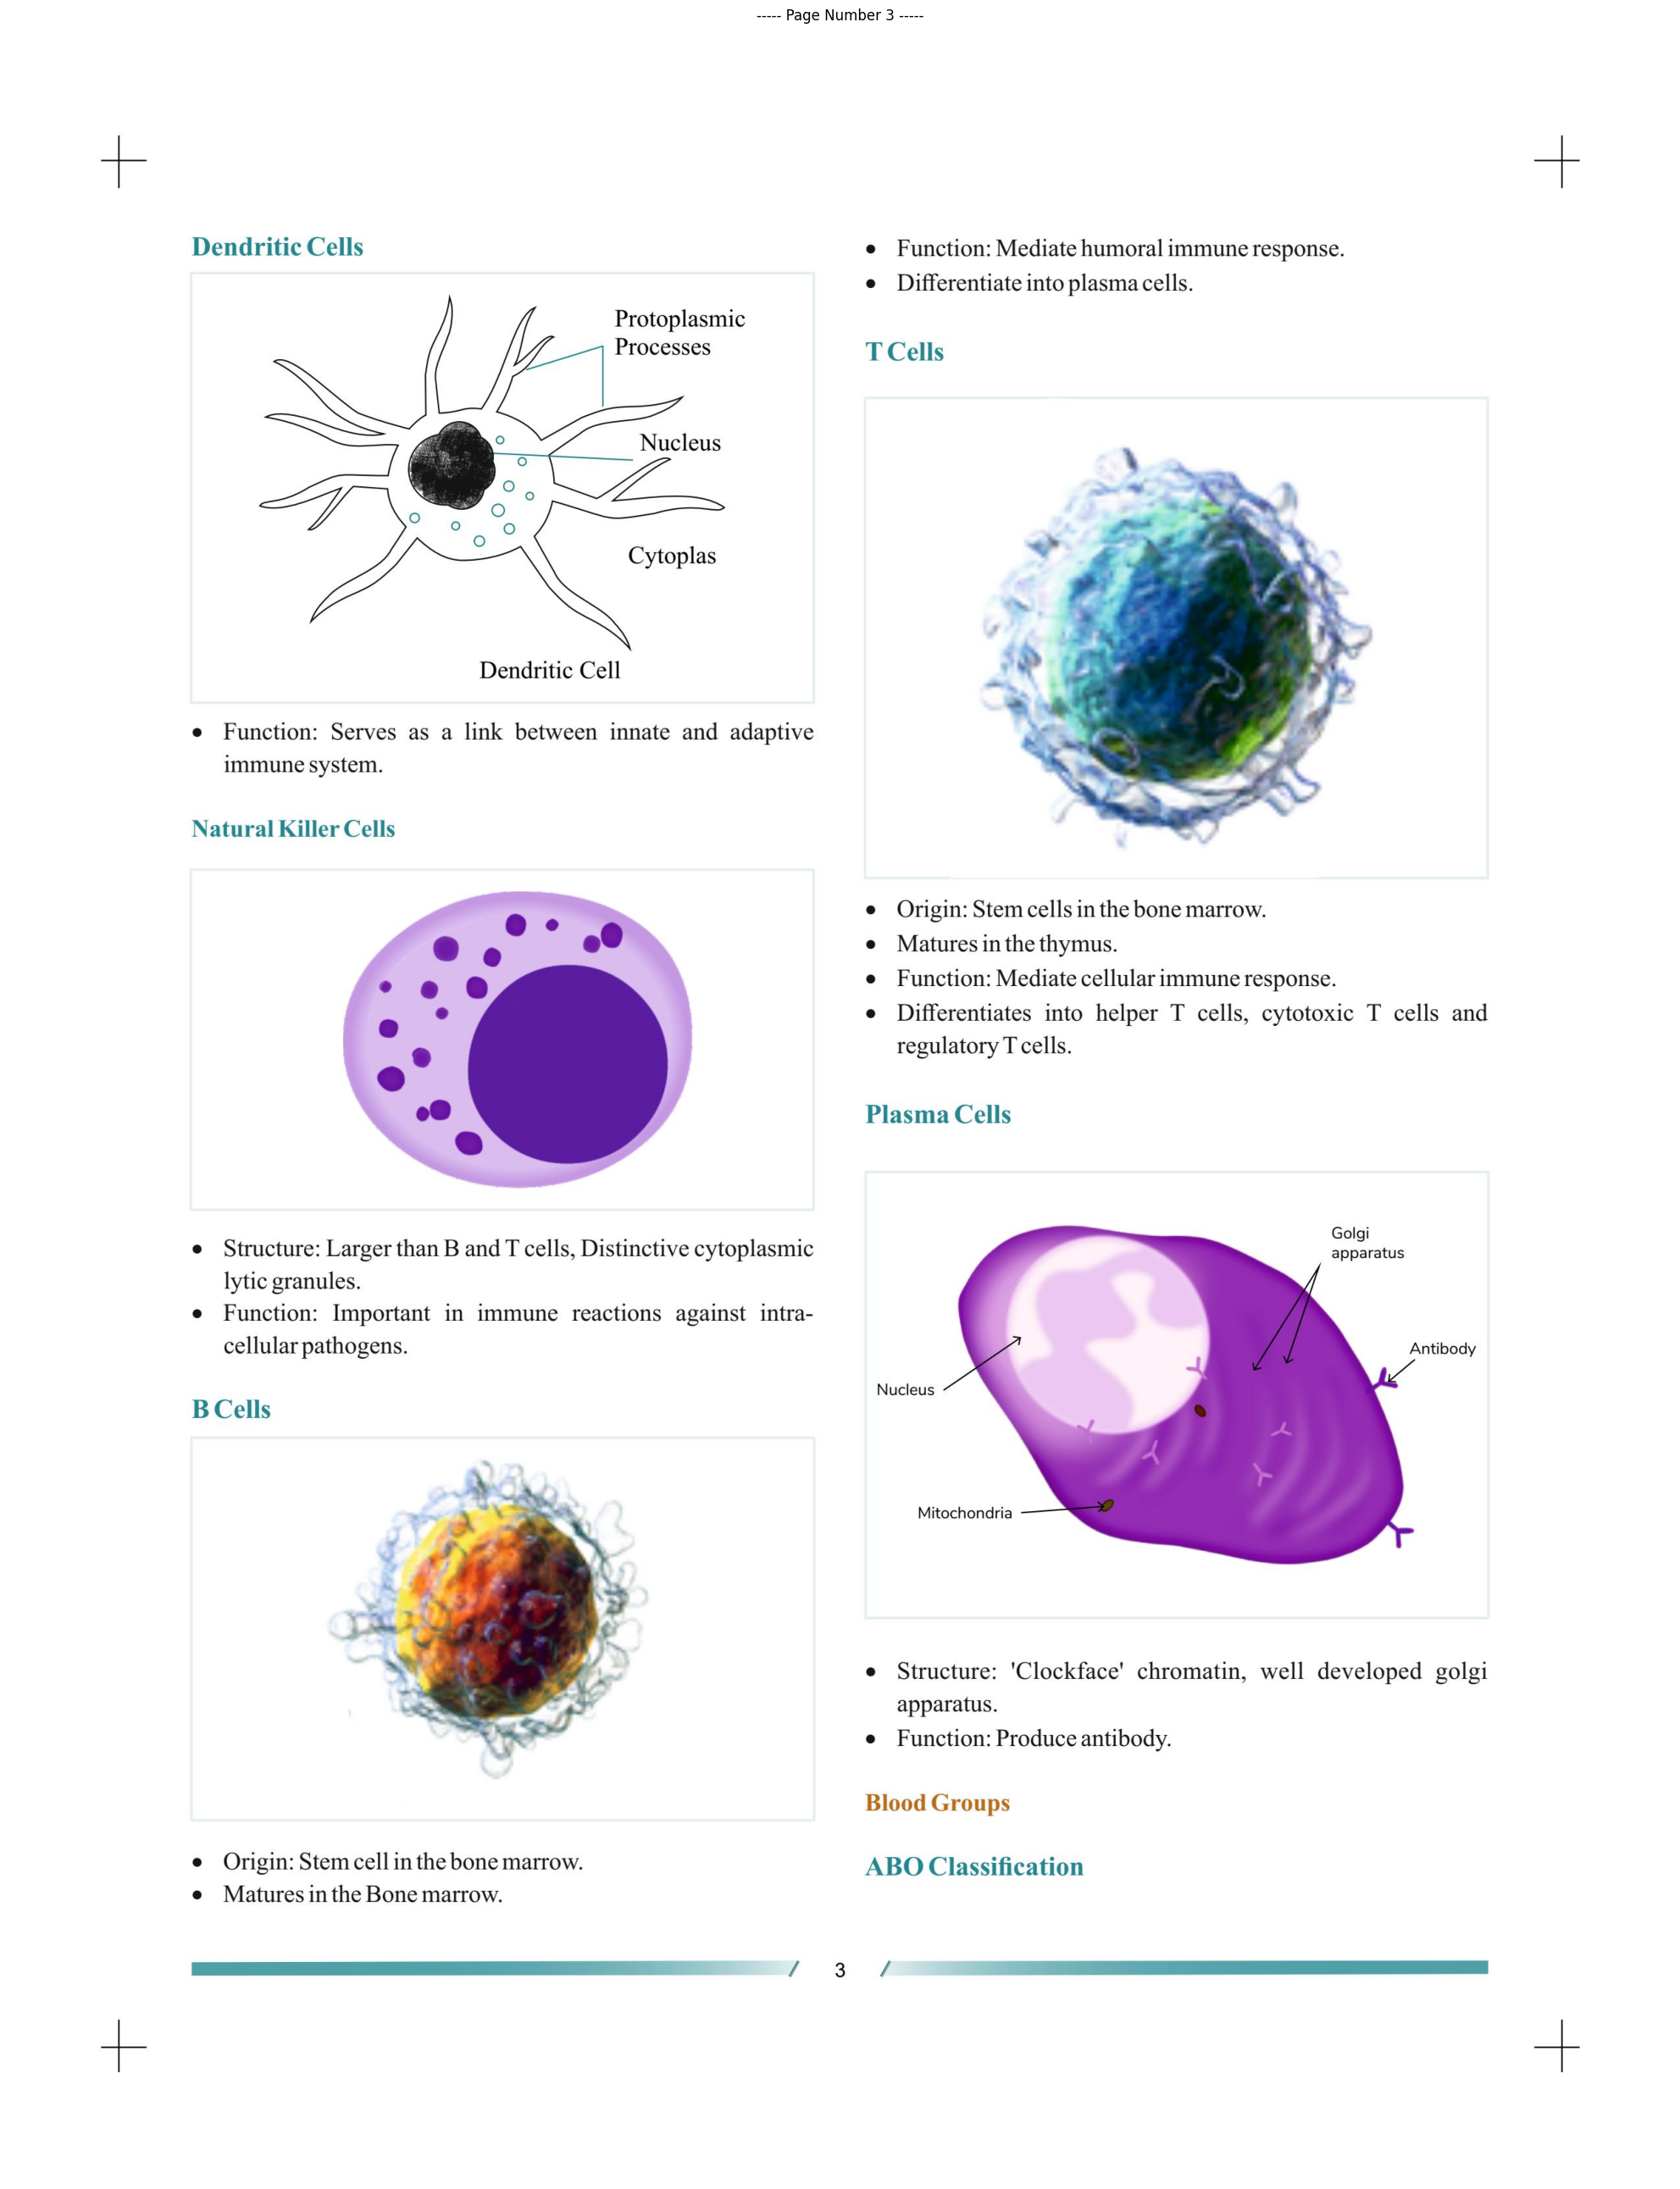

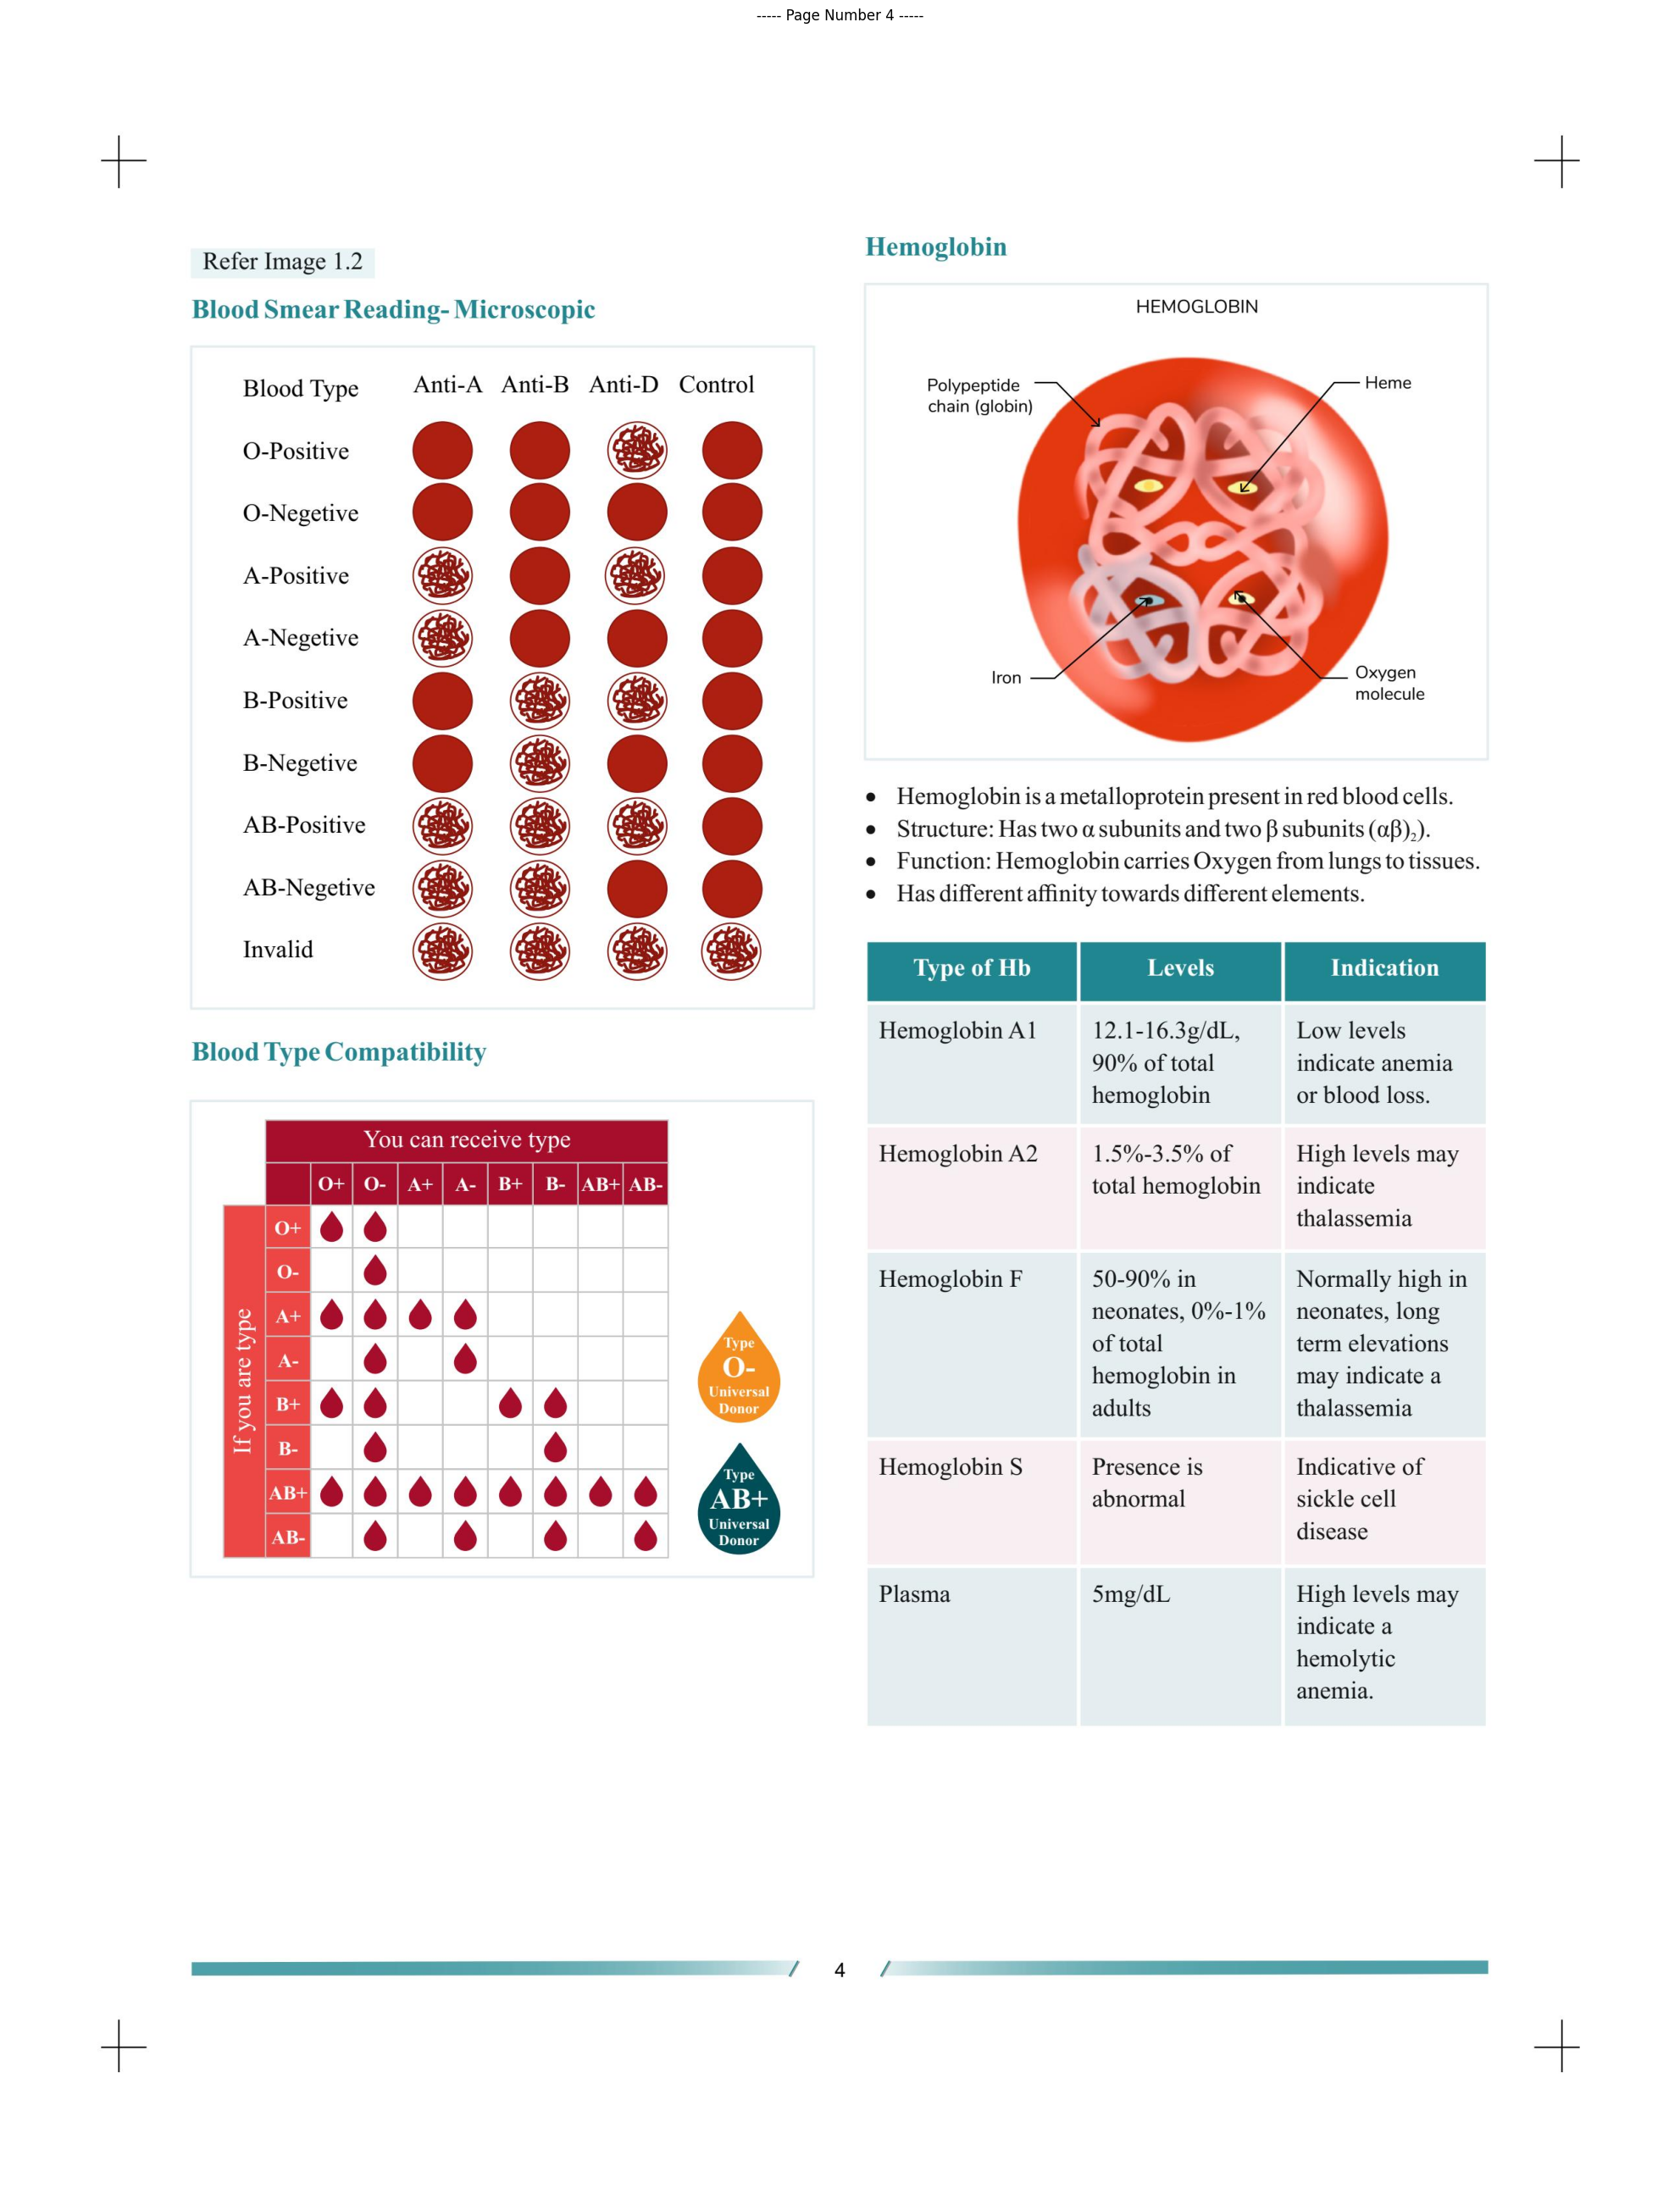

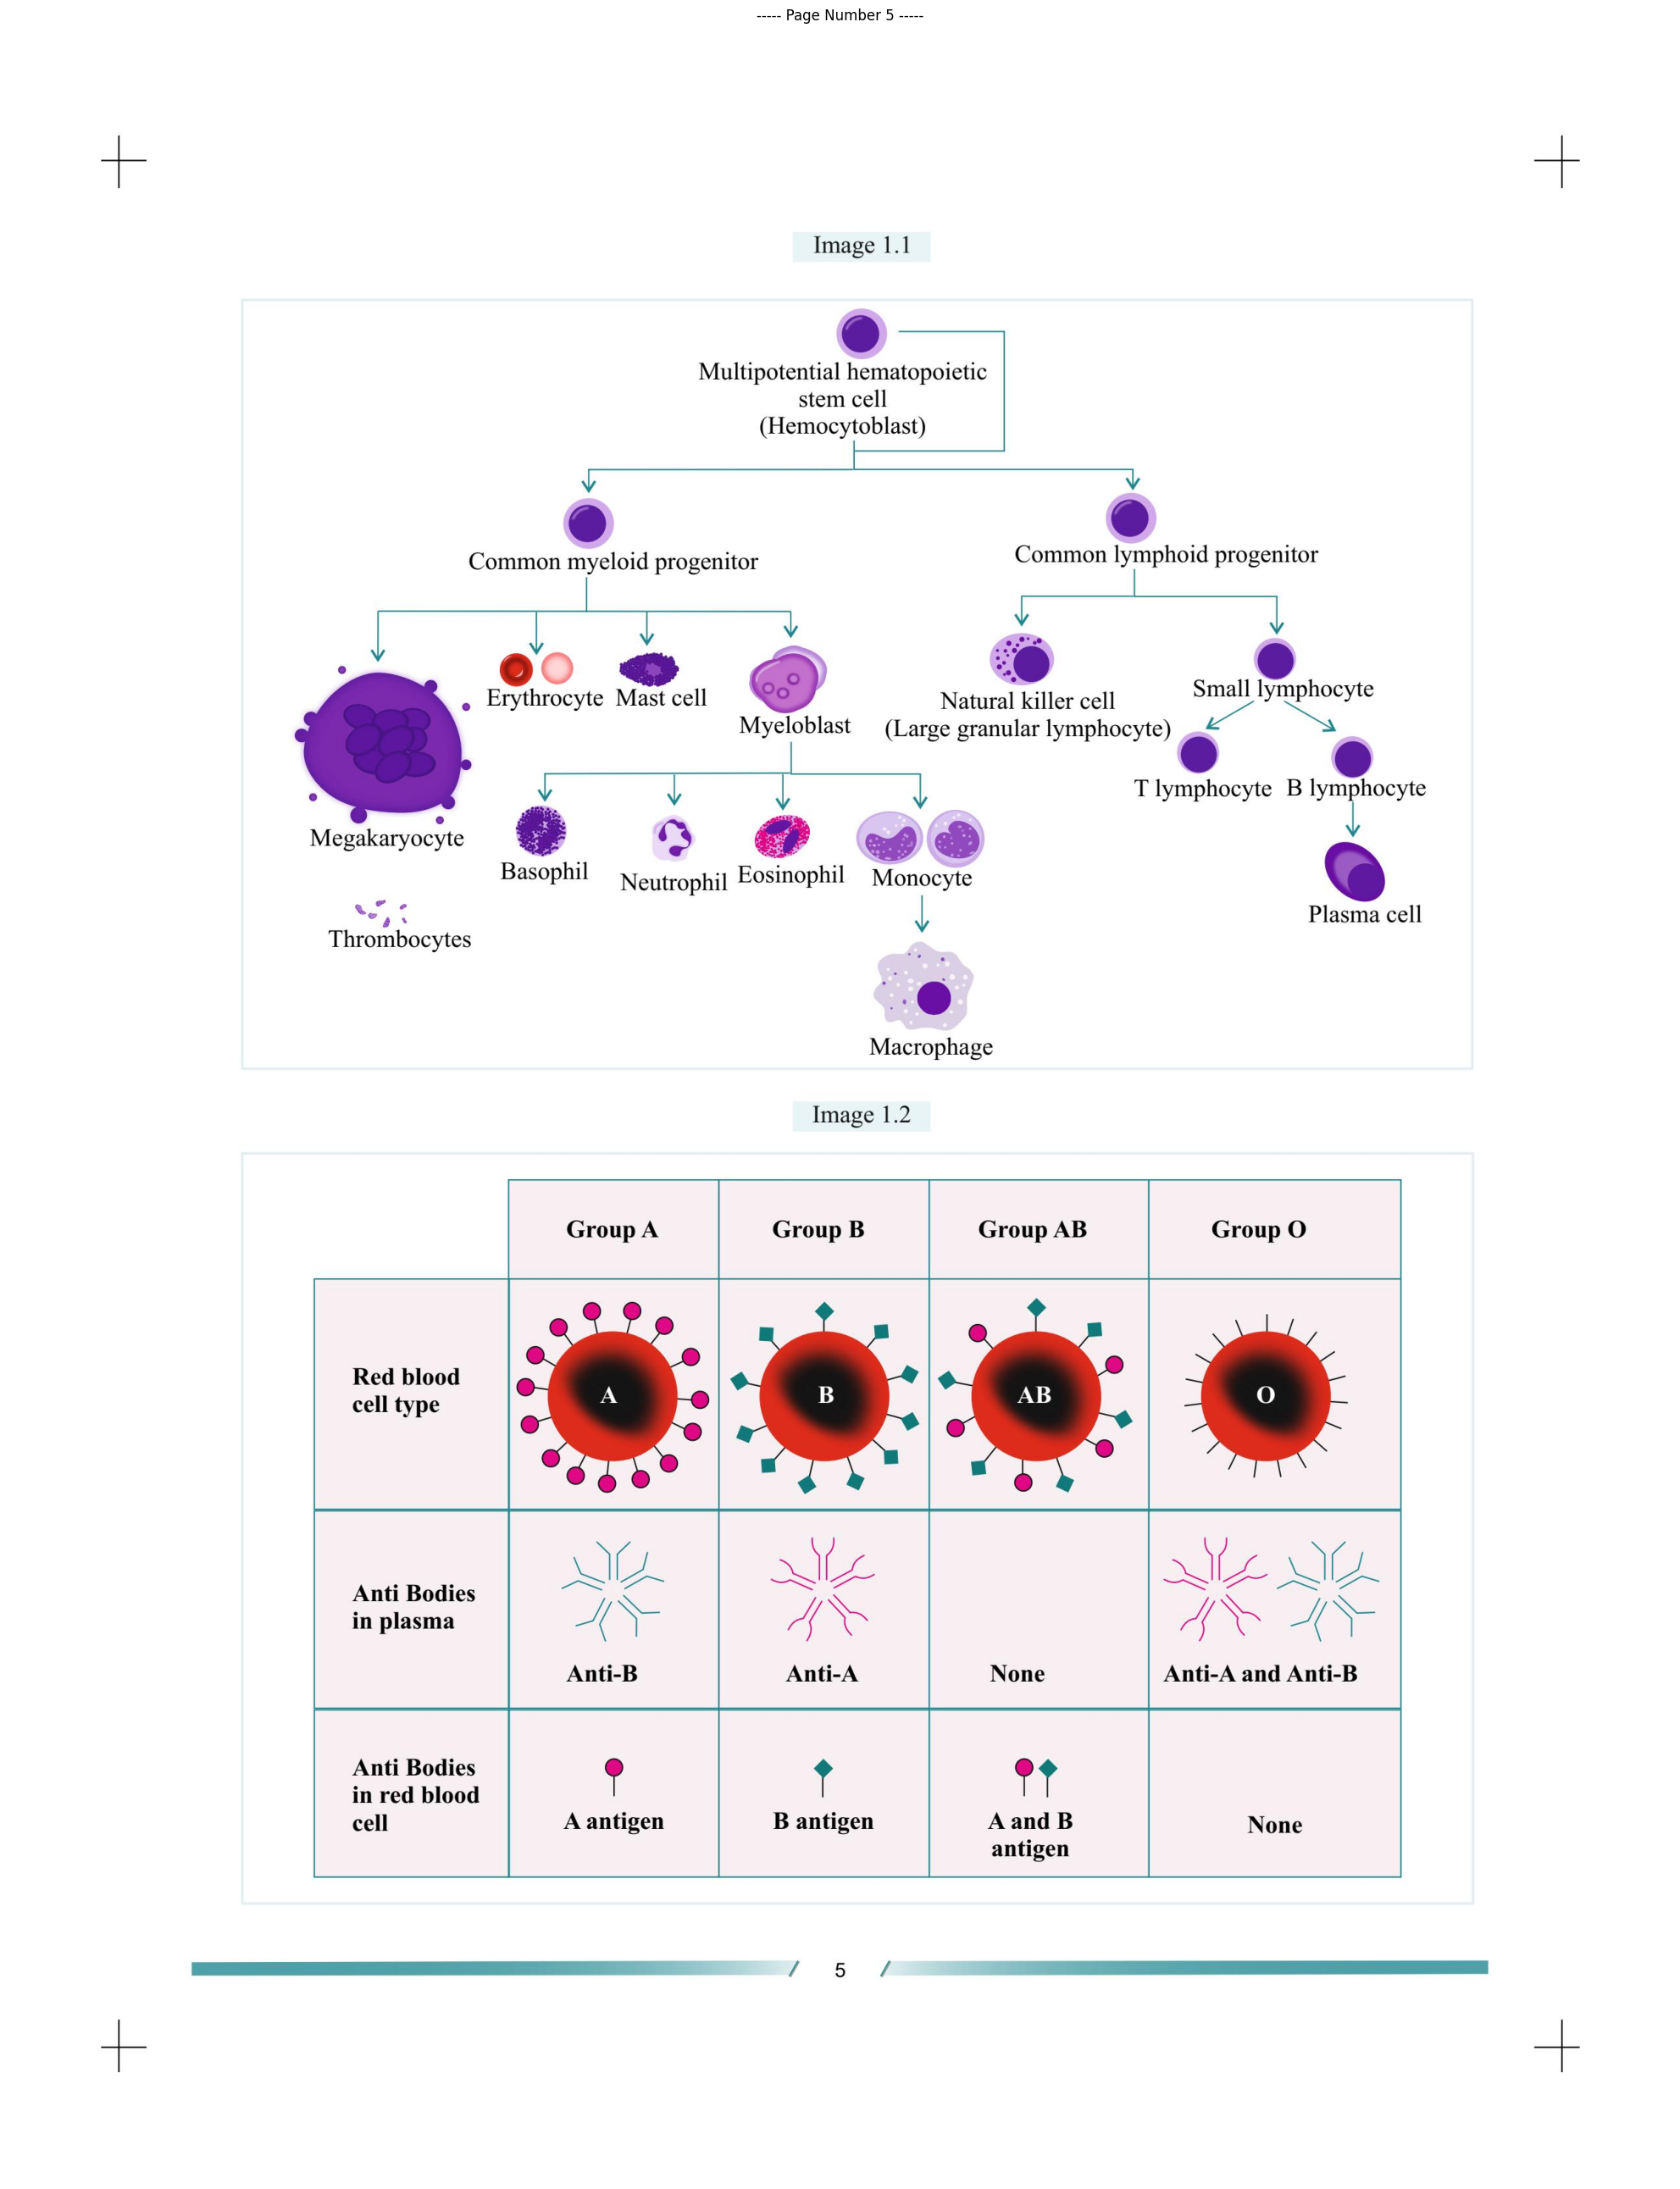

In [6]:
display_images(convert_pdf_to_images)

## Amazon Bedrock

In [14]:
import boto3
import base64
import json
import os

aws_access_key = getpass("Enter your AWS Access Key: ")
aws_secret_access_key = getpass("Enter your AWS Secret Access Key: ")
aws_session_key = getpass("Enter your AWS Session Key: ")

os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key
os.environ["AWS_SESSION_TOKEN"] = aws_session_key

bedrock_runtime = boto3.client('bedrock-runtime', region_name='us-west-2')

image_list = [list(data.values())[0] for data in convert_pdf_to_images]
image_content = []

prompt = "You are an image analyst. Please describe the photo provided."
    
for index, image_bytes in enumerate(image_list):
        
    #image = Image.open(BytesIO(image_bytes))    

    # Encoding images to base64
    base64_encoded_image = base64.b64encode(BytesIO(image_bytes).getvalue()).decode('utf-8')
    #base64.b64encode(image).decode('utf-8')
    
    # Create payloads for Bedrock Invoke, and can change model parameters to get the results you want.
    payload = {
        "modelId": "anthropic.claude-3-sonnet-20240229-v1:0",
        "contentType": "application/json",
        "accept": "application/json",
        "body": {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 4096,
            "top_k": 250,
            "top_p": 0.999,
            "temperature": 0,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/png",
                                "data": base64_encoded_image
                            }
                        },
                        {
                            "type": "text",
                            "text": prompt
                        }
                    ]
                }
            ]
        }
    }
    
    # Convert the payload to bytes
    body_bytes = json.dumps(payload['body']).encode('utf-8')
    
    # Invoke the model
    response = bedrock_runtime.invoke_model(
        body=body_bytes,
        contentType=payload['contentType'],
        accept=payload['accept'],
        modelId=payload['modelId']
    )
    
    # Process the response
    response_body = json.loads(response['body'].read())
    result = response_body['content'][0]['text']

    print (result)

The image appears to be an educational diagram or illustration from a medical textbook or reference material. It covers the topic of general anatomy and hematology, which is the study of blood and blood disorders.

The image is divided into sections that provide information and visual representations of different blood components and cells.

1. Neutrophils: A microscopic image shows a neutrophil, which is a type of white blood cell with a multi-lobed nucleus. The text explains that neutrophils participate in acute inflammatory responses and contain specific enzymes for inflammatory responses.

2. Erythrocytes (Red Blood Cells): An illustration depicts the biconcave shape and hemoglobin-rich cytoplasm of erythrocytes. The text provides details about their structure, function in oxygen and carbon dioxide transport, lifespan, energy source, and normal range values.

3. Thrombocytes (Platelets): An illustration shows the anucleate, small cytoplasmic fragments that make up thrombocytes. The